# Building a Spam Filter with Naive Bayes

In this project, we are going to make a spam filter using the multinomial Naive Bayes algorithm with a dataset of 5,572 SMS messages that have already been classified by humans. The dataset was collected by the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection) and can be downloaded directly [here](https://dq-content.s3.amazonaws.com/433/SMSSpamCollection).

Our goal is to make the spam filter classify new messages with an accuracy of over 80%. 

## Exploring the Data Set
We'll begin by reading in the data set.

In [1]:
# Reading in the data set
import pandas as pd

sms_spam = pd.read_csv('SMSSpamCollection', sep = '\t', header = None, names = ['Label', 'SMS'])

# Exploring the data set
print(sms_spam.shape)
sms_spam.head()

(5572, 2)


,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
sms_spam['Label'].value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

In [3]:
sms_spam['Label'].value_counts(normalize = True) * 100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

The data set has 5,572 rows and 2 columns. The `Label` column either classifies a message as spam or as 'ham' (non-spam). 4,825 (about 86.6%) of those rows are ham, and 747 (about 13.4%) of those rows are spam.

## Dividing the Data Set

Prior to building the spam filter, we will design a test to determine how good our spam filter is. We'll split our data set into two categories:
- A training set, which we'll use to "train" the computer on how to classify messages.
- A test set, which we'll use to test how good the spam filter is with classifying new messages.

We'll keep 80% (4,458 messages) of the data set for the training set, and 20% (1,114 messages) for the test set.

In [8]:
# Randomizing the data set
random_sms = sms_spam.sample(frac = 1, random_state = 1)

# Calculating index for the split
training_index = round(len(random_sms) * 0.8)

# Creating the training and test sets
training_set = random_sms[:training_index].reset_index(drop = True)
test_set = random_sms[training_index:].reset_index(drop = True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


Let's see the percentage of spam and ham in both sets. We expect the percentages to be close to what we have in the full dataset (86.6% of the messages are ham, and 13.4% of the messages are spam).

In [9]:
training_set['Label'].value_counts(normalize = True) * 100

ham     86.54105
spam    13.45895
Name: Label, dtype: float64

In [10]:
test_set['Label'].value_counts(normalize = True) * 100

ham     86.804309
spam    13.195691
Name: Label, dtype: float64

The results resemble what we expect. We'll move on to cleaning the data set.

## Data Cleaning
Our Naive Bayes algorithm requires probabilities that we can obtain once we clean the data set. We want to bring the data to this format: 

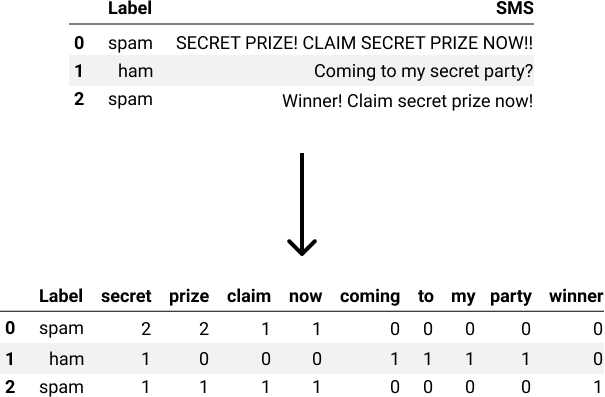

### Letter Case and Punctuation

We'll start by removing all punctuation and making every letter lower case.

In [11]:
# Pre-cleaning
training_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [12]:
# Cleaning
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')
training_set['SMS'] = training_set['SMS'].str.lower()

# Post-cleaning
training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


### Creating the Vocabulary
We'll now move on to creating the vocabulary (i.e. the list with all the words in our training set).


In [13]:
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for message in training_set['SMS']:
    for word in message:
        vocabulary.append(word)
        
vocabulary = list(set(vocabulary)) # We transform vocabulary into a list to remove duplicates, then change it back to a list

len(vocabulary)

7783

It appears there are 7,783 unique words in all the messages of our training set.

### Completing the Training Set

We'll now use the vocabulary we just created to make the data transformation we want.

In [14]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [15]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,vargu,suppose,3x,hun,weirdo,ummmmmaah,official,eek,kickoff,seeking,...,09096102316,juicy,occasion,shes,09064019014,objection,08717507382,even,1450,recent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
training_set_clean = pd.concat([training_set, word_counts], axis = 1)
training_set_clean.head()

,Label,SMS,vargu,suppose,3x,hun,weirdo,ummmmmaah,official,eek,...,09096102316,juicy,occasion,shes,09064019014,objection,08717507382,even,1450,recent
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculating Constants First
Now that we're done cleaning the training set, we can start creating the spam filter. The Naive Bayes algorithm will need to answer these two probability questions to be able to classify new messages:
<br>
<br>
<center>$P(Spam|w_{1}, w_{2},...,w_{n})\propto \text{P(Spam) } \cdot \Pi^n_{i = 1} P(W_{i} | Spam)$</center>
<br>
<center>$P(Ham|w_{1}, w_{2},...,w_{n})\propto \text{P(Ham) } \cdot \Pi^n_{i = 1} P(W_{i} | Ham)$</center>
<br>
Also, to calculate $P(w_{i}|Spam)$ and $P(w_{i}|Ham)$ inside the formulas above, we'll need to use these equations:
<br>
<br>
<center>$P(w_{i}|Spam) = \large \frac{N_{w_{i}|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}$</center>
<br>
<center>$P(w_{i}|Ham) = \large \frac{N_{w_{i}|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}$</center>
Some of the terms in the four equations above will have the same value for every new message. We can calculate the value of these terms once and avoid doing the computations again when a new message comes in. We'll use our training set to calculate:

- $\text{P(Spam)}$ and $\text{P(Ham)}$
- $N_{\text{Spam}}$, $N_{\text{Ham}}$, $N_{\text{Vocabulary}}$

We'll also use Laplace smoothing and set $\alpha = 1$.

In [19]:
# Isolating the spam and ham messages
spam_sms = training_set_clean[training_set_clean['Label'] == 'spam']
ham_sms = training_set_clean[training_set_clean['Label'] == 'ham']

# Finding P(Spam) and P(Ham)
p_spam = len(spam_sms) / len(training_set_clean)
p_ham = len(ham_sms) / len(training_set_clean)

# Finding number of spam messages
n_words_per_spam_sms = spam_sms['SMS'].apply(len)
n_spam = n_words_per_spam_sms.sum()

# Finding number of ham messages
n_words_per_ham_sms = ham_sms['SMS'].apply(len)
n_ham = n_words_per_ham_sms.sum()

# Finding the length of the vocabulary
n_vocab = len(vocabulary)

# Laplace smoothing
alpha = 1

## Calculating Parameters

Now that we have the constant terms calculated above, we can move on with calculating $P(w_{i}|\text{Spam})$ and $P(w_{i}|\text{Ham})$. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:
<br>
<br>
<center>$P(w_{i}|Spam) = \large \frac{N_{w_{i}|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}$</center>
<br>
<center>$P(w_{i}|Ham) = \large \frac{N_{w_{i}|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}$</center>

In [22]:
# Initializing the parameters
param_spam = {unique_word: 0 for unique_word in vocabulary}
param_ham = {unique_word: 0 for unique_word in vocabulary}

# Calculating the parameters
for word in vocabulary:
    n_word_given_spam = spam_sms[word].sum() # spam_sms was already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + (alpha * n_vocab))
    param_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_sms[word].sum() # ham_sms was already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + (alpha * n_vocab))
    param_ham[word] = p_word_given_ham

## Classifying a New Message

Now that we have calculated all of our parameters, we can start making the spam filter. The spam filter can be thought of as a function that:
- Takes a new message as input ($w_{1}, w_{2}, ..., w_{n}$).
- Calculates $P(\text{Spam}|w_{1}, w_{2}, ..., w_{n})$ and $P(\text{Ham}|w_{1}, w_{2}, ..., w_{n})$.
- Compares the values of $P(\text{Spam}|w_{1}, w_{2}, ..., w_{n})$ and $P(\text{Ham}|w_{1}, w_{2}, ..., w_{n})$, and:
    - If $P(\text{Ham}|w_{1}, w_{2}, ..., w_{n}) > P(\text{Spam}|w_{1}, w_{2}, ..., w_{n})$, then the message is classified as ham.
    - If $P(\text{Ham}|w_{1}, w_{2}, ..., w_{n}) < P(\text{Spam}|w_{1}, w_{2}, ..., w_{n})$, then the message is classified as spam.
    - If $P(\text{Ham}|w_{1}, w_{2}, ..., w_{n}) = P(\text{Spam}|w_{1}, w_{2}, ..., w_{n})$, then the algorithm may request human help.

In [25]:
import re

def classify(message):
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message) # Removing punctuation
    message = message.lower() # Bringing all letters to lower case
    message = message.split()

    p_spam_given_sms = p_spam
    p_ham_given_sms = p_ham
    
    for word in message:
        if word in param_spam:
            p_spam_given_sms *= param_spam[word]
            
        if word in param_ham:
            p_ham_given_sms *= param_ham[word]

    print('P(Spam|message):', p_spam_given_sms)
    print('P(Ham|message):', p_ham_given_sms)

    if p_ham_given_sms > p_spam_given_sms:
        print('Label: Ham')
    elif p_ham_given_sms < p_spam_given_sms:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [29]:
classify('YOU HAVE JUST WON BIG MONEY!! ENTER SECRET CODE: C3124')

P(Spam|message): 1.1547306493259102e-28
P(Ham|message): 3.22027718822571e-30
Label: Spam


In [31]:
classify("All right, sounds good, see you there.")

P(Spam|message): 2.0157829473817623e-24
P(Ham|message): 1.9431682118396506e-19
Label: Ham


## Measuring the Spam Filter's Accuracy

The two practice results look promising, but let's see how our filter fares on our test set, comprising 1,114 messages.

We'll start by writing a function that returns classification labels instead of printing them.

In [32]:
def classify_test_set(message):    
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_sms = p_spam
    p_ham_given_sms = p_ham

    for word in message:
        if word in param_spam:
            p_spam_given_sms *= param_spam[word]
            
        if word in param_ham:
            p_ham_given_sms *= param_ham[word]
    
    if p_ham_given_sms > p_spam_given_sms:
        return 'ham'
    elif p_spam_given_sms > p_ham_given_sms:
        return 'spam'
    else:
        return 'needs human classification'

Now that we have a function that returns labels instead of printing them, we can use it to create a new column in our test set.

In [33]:
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


Let's write a function to measure the accuracy of our spam filter to determine how well our spam filter performs.

In [35]:
correct = 0
total = test_set.shape[0]

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
        
print('Correct: ', correct)
print('Wrong: ', total - correct)
print('Accuracy:', correct / total * 100)

Correct:  1100
Wrong:  14
Accuracy: 98.74326750448833


The accuracy of our spam filter is about 98.74%. Our spam filter looked at 1,114 messages that it hasn't seen in the training set, and classified 1,100 correctly.

## Conclusion
We managed to make a spam filter with an accuracy of about 98.74%, using the multinomial Naive Bayes algorithm. Our initial goal was an accuracy of over 80%, and we managed to go beyond what we had in mind. 